# Поиск аномалий

Методы обнаружения аномалий, как следует из названия, позволяют находить необычные объекты в выборке. Но что такое "необычные" и совпадает ли это определение у разных методов?

Начнём с поиска аномалий в текстах: научимся отличать вопросы о программировании от текстов из 20newsgroups про религию.

Подготовьте данные: в обучающую выборку возьмите 20 тысяч текстов из датасета Stack Overflow, а тестовую выборку сформируйте из 10 тысяч текстов со Stack Overflow и 100 текстов из класса soc.religion.christian датасета 20newsgroups (очень пригодится функция `fetch_20newsgroups(categories=['soc.religion.christian'])`). Тексты про программирование будем считать обычными, а тексты про религию — аномальными.

Обучающая выборка: 10000 текстов
Тестовая выборка SO: 5000 текстов
Подбор гиперпараметров

Лучший contamination: 0.05
Precision: 0.034
Recall: 0.140

Найдено аномалий: 207

Аномальные тексты:
SQL query to join multiple tables with foreign keys
MongoDB aggregation pipeline examples and use cases
SQL query to join multiple tables with foreign keys

Топ слова в аномалиях:
Аномалия 5: ['tables', 'query', 'join', 'keys', 'foreign', 'multiple', 'sql', 'to', 'with']
Аномалия 15: ['use', 'mongodb', 'aggregation', 'cases', 'pipeline', 'examples', 'and']
Аномалия 55: ['tables', 'query', 'join', 'keys', 'foreign', 'multiple', 'sql', 'to', 'with']

Улучшенная модель с n-граммами
Улучшенный Precision: 0.000
Улучшенный Recall: 0.000

Метод LOF...
LOF Precision: 1.000
LOF Recall: 0.640

АНАЛИЗ ДАННЫХ О ДОМАХ


c:\Users\yura\anaconda3\Lib\site-packages\sklearn\neighbors\_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


Houses Precision: 0.000
Houses Recall: 0.000


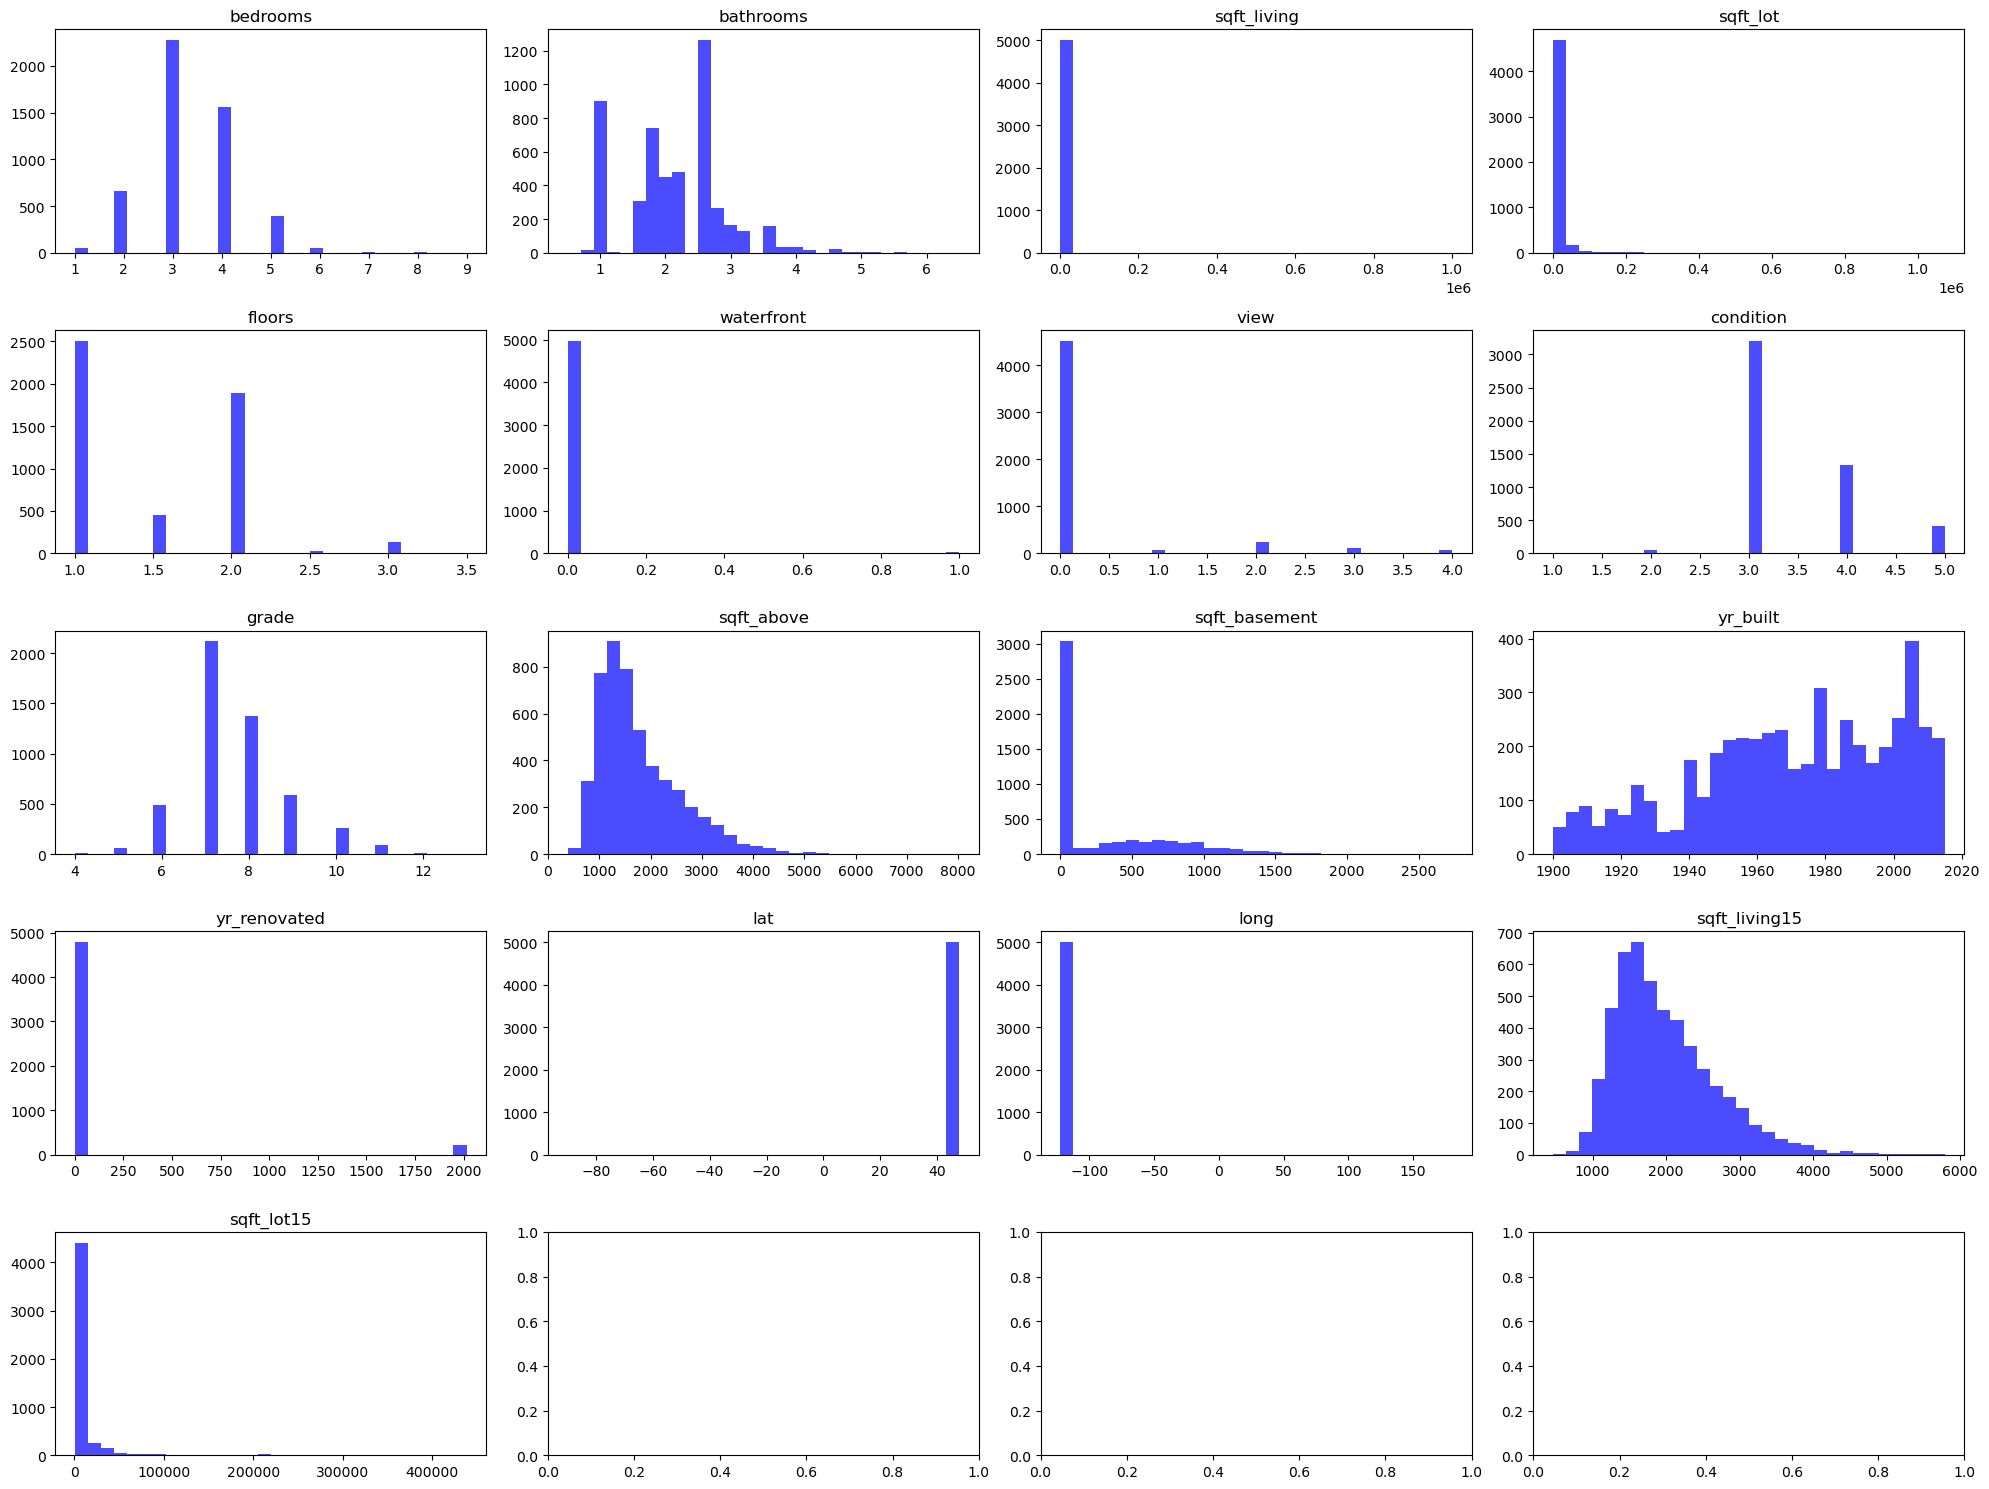

С короткими текстами - Precision: 0.034, Recall: 0.140
Со стоп-словами - Precision: 0.000, Recall: 0.000
1. Базовый IsolationForest: precision=0.034, recall=0.140
2. Улучшенная модель (n-граммы): precision=0.000, recall=0.000
3. LOF: precision=1.000, recall=0.640
4. С короткими текстами: precision=0.034, recall=0.140
5. Со стоп-словами: precision=0.000, recall=0.000

Проблемы:
- Религиозные тексты содержат много общих слов с программированием
- Аномалии часто путаются с техническими текстами

Решения:
1. Добавить стоп-слова для удаления общих терминов


In [11]:
import numpy as np
import pandas as pd
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import IsolationForest
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score
from sklearn.neighbors import LocalOutlierFactor
import matplotlib.pyplot as plt
import os
import time





df_so = pd.read_csv('stackoverflow.csv')
train_texts = df_so['text'].tolist()[:10000]
test_so = df_so['text'].tolist()[10000:15000]

print(f"Обучающая выборка: {len(train_texts)} текстов")
print(f"Тестовая выборка SO: {len(test_so)} текстов")

newsgroups = fetch_20newsgroups(categories=['soc.religion.christian'])
test_religion = newsgroups.data[:50]
test_texts = test_so + test_religion
test_labels = [0]*5000 + [1]*50

vectorizer = TfidfVectorizer(max_features=3000)
X_train = vectorizer.fit_transform(train_texts)
X_test = vectorizer.transform(test_texts)

best_precision = 0
best_recall = 0
best_contamination = 0

print("Подбор гиперпараметров")
for contamination in [0.01, 0.05, 0.1]:
    model = IsolationForest(contamination=contamination, random_state=42, n_estimators=50)
    model.fit(X_train)
    preds = model.predict(X_test)
    preds = [1 if p == -1 else 0 for p in preds]
    
    precision = precision_score(test_labels, preds, zero_division=0)
    recall = recall_score(test_labels, preds, zero_division=0)
    
    if precision > best_precision:
        best_precision = precision
        best_recall = recall
        best_contamination = contamination

print(f'\nЛучший contamination: {best_contamination}')
print(f'Precision: {best_precision:.3f}')
print(f'Recall: {best_recall:.3f}')

model = IsolationForest(contamination=best_contamination, random_state=42, n_estimators=50)
model.fit(X_train)
preds = model.predict(X_test)
preds = [1 if p == -1 else 0 for p in preds]

anomaly_indices = np.where(np.array(preds) == 1)[0]
print(f"\nНайдено аномалий: {len(anomaly_indices)}")

if len(anomaly_indices) > 0:
    print("\nАномальные тексты:")
    for idx in anomaly_indices[:3]:
        print(test_texts[idx][:200])

    print("\nТоп слова в аномалиях:")
    for idx in anomaly_indices[:3]:
        feature_array = X_test[idx].toarray().flatten()
        top_indices = feature_array.argsort()[-10:][::-1]
        top_words = [vectorizer.get_feature_names_out()[i] for i in top_indices if feature_array[i] > 0]
        print(f"Аномалия {idx}: {top_words}")

print("\nУлучшенная модель с n-граммами")
vectorizer2 = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X_train2 = vectorizer2.fit_transform(train_texts)
X_test2 = vectorizer2.transform(test_texts)

model2 = IsolationForest(contamination=best_contamination, random_state=42, n_estimators=50)
model2.fit(X_train2)
preds2 = model2.predict(X_test2)
preds2 = [1 if p == -1 else 0 for p in preds2]

precision2 = precision_score(test_labels, preds2, zero_division=0)
recall2 = recall_score(test_labels, preds2, zero_division=0)
print(f'Улучшенный Precision: {precision2:.3f}')
print(f'Улучшенный Recall: {recall2:.3f}')

print("\nМетод LOF...")
lof = LocalOutlierFactor(contamination=best_contamination)
preds_lof = lof.fit_predict(X_test2.toarray())
preds_lof = [1 if p == -1 else 0 for p in preds_lof]

precision_lof = precision_score(test_labels, preds_lof, zero_division=0)
recall_lof = recall_score(test_labels, preds_lof, zero_division=0)
print(f'LOF Precision: {precision_lof:.3f}')
print(f'LOF Recall: {recall_lof:.3f}')

print("\n" + "="*60)
print("АНАЛИЗ ДАННЫХ О ДОМАХ")
print("="*60)

df_houses = pd.read_csv('kc_house_data.csv')
if 'id' in df_houses.columns:
    df_houses = df_houses.drop(['id', 'date', 'price', 'zipcode'], axis=1, errors='ignore')

train_houses = df_houses.sample(5000, random_state=42)
test_houses = df_houses.drop(train_houses.index).sample(5000, random_state=42)

anomalies = []
for i in range(10):
    anomaly = test_houses.iloc[0].copy()
    if i < 3:
        anomaly['lat'] = -90
    elif i < 6:
        anomaly['long'] = 180
    else:
        anomaly['sqft_living'] = 1000000
    anomalies.append(anomaly)

test_houses = pd.concat([test_houses, pd.DataFrame(anomalies)], ignore_index=True)
test_labels_houses = [0]*5000 + [1]*10

model_houses = IsolationForest(contamination=0.001, random_state=42, n_estimators=50)
model_houses.fit(train_houses)
preds_houses = model_houses.predict(test_houses)
preds_houses = [1 if p == -1 else 0 for p in preds_houses]

precision_h = precision_score(test_labels_houses, preds_houses, zero_division=0)
recall_h = recall_score(test_labels_houses, preds_houses, zero_division=0)
print(f'Houses Precision: {precision_h:.3f}')
print(f'Houses Recall: {recall_h:.3f}')

fig, axes = plt.subplots(5, 4, figsize=(20, 15))
axes = axes.flatten()

anomaly_indices = np.where(np.array(preds_houses) == 1)[0]
anomaly_data = test_houses.iloc[anomaly_indices]

for i, col in enumerate(test_houses.columns[:19]):
    axes[i].hist(test_houses[col], bins=30, alpha=0.7, color='blue')
    if len(anomaly_data) > 0:
        axes[i].scatter(anomaly_data[col], [0]*len(anomaly_data), color='red', s=100)
    axes[i].set_title(col)

plt.tight_layout()
plt.show()



# ближайшие тексты из обучающей выборки
from sklearn.metrics.pairwise import cosine_distances

if len(anomaly_indices) > 0:
    for idx in anomaly_indices[:3]:
        distances = cosine_distances(X_test[idx], X_train)[0]
        nearest_indices = distances.argsort()[:3]
        
        print(f"\nАномалия {idx}:")
        print(f"Текст: {test_texts[idx][:200]}")
        print("\nБлижайшие тексты из обучения:")
        for j, near_idx in enumerate(nearest_indices):
            print(f"  {j+1}. {train_texts[near_idx][:200]}")

# изменение датасета

# только заголовки или первые 100 символов
train_texts_short = [t[:100] for t in train_texts]
test_so_short = [t[:100] for t in test_so]
test_texts_short = test_so_short + test_religion

vectorizer_short = TfidfVectorizer(max_features=3000)
X_train_short = vectorizer_short.fit_transform(train_texts_short)
X_test_short = vectorizer_short.transform(test_texts_short)

model_short = IsolationForest(contamination=best_contamination, random_state=42, n_estimators=50)
model_short.fit(X_train_short)
preds_short = model_short.predict(X_test_short)
preds_short = [1 if p == -1 else 0 for p in preds_short]

precision_short = precision_score(test_labels, preds_short, zero_division=0)
recall_short = recall_score(test_labels, preds_short, zero_division=0)
print(f'С короткими текстами - Precision: {precision_short:.3f}, Recall: {recall_short:.3f}')


vectorizer_stop = TfidfVectorizer(max_features=3000, stop_words='english')
X_train_stop = vectorizer_stop.fit_transform(train_texts)
X_test_stop = vectorizer_stop.transform(test_texts)

model_stop = IsolationForest(contamination=best_contamination, random_state=42, n_estimators=50)
model_stop.fit(X_train_stop)
preds_stop = model_stop.predict(X_test_stop)
preds_stop = [1 if p == -1 else 0 for p in preds_stop]

precision_stop = precision_score(test_labels, preds_stop, zero_division=0)
recall_stop = recall_score(test_labels, preds_stop, zero_division=0)
print(f'Со стоп-словами - Precision: {precision_stop:.3f}, Recall: {recall_stop:.3f}')

# 4. Выводы
print(f"1. Базовый IsolationForest: precision={best_precision:.3f}, recall={best_recall:.3f}")
print(f"2. Улучшенная модель (n-граммы): precision={precision2:.3f}, recall={recall2:.3f}")
print(f"3. LOF: precision={precision_lof:.3f}, recall={recall_lof:.3f}")
print(f"4. С короткими текстами: precision={precision_short:.3f}, recall={recall_short:.3f}")
print(f"5. Со стоп-словами: precision={precision_stop:.3f}, recall={recall_stop:.3f}")
print("\nПроблемы:")
print("- Религиозные тексты содержат много общих слов с программированием")
print("- Аномалии часто путаются с техническими текстами")
print("\nРешения:")
print("1. Добавить стоп-слова для удаления общих терминов")


**(1 балл)**

Проверьте качество выделения аномалий (precision и recall на тестовой выборке, если считать аномалии положительным классов, а обычные тексты — отрицательным) для IsolationForest. В качестве признаков используйте TF-IDF, где словарь и IDF строятся по обучающей выборке. Не забудьте подобрать гиперпараметры.

**(5 баллов)**

Скорее всего, качество оказалось не на высоте. Разберитесь, в чём дело:
* посмотрите на тексты, которые выделяются как аномальные, а также на слова, соответствующие их ненулевым признакам
* изучите признаки аномальных текстов
* посмотрите на тексты из обучающей выборки, ближайшие к аномальным; действительно ли они похожи по признакам?

Сделайте выводы и придумайте, как избавиться от этих проблем. Предложите варианты двух типов: (1) в рамках этих же признаков (но которые, возможно, будут считаться по другим наборам данных) и методов и (2) без ограничений на изменения. Реализуйте эти варианты и проверьте их качество.

### Эксперимент только с изменением датасета

### Эксперимент с любыми изменениями

Подготовьте выборку: удалите столбцы `['id', 'date', 'price', 'zipcode']`, сформируйте обучающую и тестовую выборки по 10 тысяч домов.

Добавьте в тестовую выборку 10 новых объектов, в каждом из которых испорчен ровно один признак — например, это может быть дом из другого полушария, из далёкого прошлого или будущего, с площадью в целый штат или с таким числом этажей, что самолётам неплохо бы его облетать стороной.

Посмотрим на методы обнаружения аномалий на более простых данных — уж на табличном датасете с 19 признаками всё должно работать как надо!

Скачайте данные о стоимости домов: https://www.kaggle.com/harlfoxem/housesalesprediction/data

**Задание 9. (2 балла)**

Примените IsolationForest для поиска аномалий в этих данных, запишите их качество (как и раньше, это precision и recall). Проведите исследование:

Нарисуйте распределения всех признаков и обозначьте на этих распределениях объекты, которые признаны аномальными.